In [99]:
import pandas as pd
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df_metadata = pd.read_csv(f'{base_dir}/raw_data/station_metadata.csv')

In [139]:
# station_id = df_metadata.iloc[2]['station_id']
for station_id in df_metadata['station_id']:
    df_gauge = pd.read_csv(f"{base_dir}/raw_data/gauge_observations/{station_id}.csv", dtype={'measurement': str}).query('DQF == "A"').drop(columns=['DQF', 'station_id'])
    if len(df_gauge) == 0:
        print(f"{station_id}\n\tNO DATA")
        continue

    df_gauge['hst_timestamp'] = pd.to_datetime(df_gauge['hst_timestamp'])
    df_gauge['measurement'] = np.array(df_gauge['measurement'])
    df_gauge.set_index('hst_timestamp', inplace=True)

    df_gauge_resampled = df_gauge.resample('1h').max()
    n_potential = df_gauge_resampled.shape[0]
    n_actual = df_gauge_resampled.dropna().shape[0]
    output = f"{station_id}\n" \
        + f"\tData Range {df_gauge.index.min().strftime('%Y/%m/%d')} ~ {df_gauge.index.max().strftime('%Y/%m/%d')}" \
        + f"\n\t{n_actual/n_potential * 100:.2f}% data available ({n_actual}/{n_potential})"
    print(output)

16104200
	Data Range 2008/12/13 ~ 2025/01/27
	0.17% data available (246/141338)
16103000
	Data Range 2007/10/01 ~ 2022/08/10
	89.72% data available (116865/130260)
16097500
	Data Range 2007/10/01 ~ 2025/02/28
	91.62% data available (139873/152664)
16094150
	Data Range 2007/10/01 ~ 2024/08/21
	81.80% data available (121131/148075)
16114800
	Data Range 2019/05/17 ~ 2025/07/22
	35.36% data available (19161/54190)
16108000
	Data Range 2007/10/01 ~ 2025/07/17
	88.31% data available (137752/155986)
16010000
	Data Range 2007/10/01 ~ 2025/05/20
	90.93% data available (140571/154599)
16016000
	NO DATA
16019000
	Data Range 2007/10/01 ~ 2025/07/23
	85.74% data available (133869/156131)
16060950
	NO DATA
16068000
	Data Range 2007/10/01 ~ 2025/05/27
	87.00% data available (134652/154764)
16071500
	Data Range 2007/10/01 ~ 2025/02/11
	90.39% data available (137610/152244)
16057900
	Data Range 2015/11/12 ~ 2024/01/25
	91.12% data available (65514/71899)
16060000
	Data Range 2007/10/01 ~ 2021/10/14
	90

In [131]:
station_id

16016000

In [1]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tqdm import tqdm
import zarr
from wrf_diffusion.nimbuspp.parallel import parallelize
from wrf_diffusion.config import BASE_DIR
import os

In [10]:
era5_filename = f"{BASE_DIR}/preprocessed_data/ml_datasets/v6/ERA5.zarr"
# os.path.exists(era5_filename)
with zarr.open(era5_filename) as f:
    print(f['data'].attrs['varnames'][-1])
    df_era5 = pd.DataFrame(
        data={'utc_timestamp':pd.to_datetime(f['utc_timestamp'][60000:61000], unit='s', utc=True),
              'q-700':f['data']['kauai'][60000:61000,10,0,2],
              'q-850':f['data']['kauai'][60000:61000,11,0,2],
              'tcwv':f['data']['kauai'][60000:61000,-1,0,2]
              })

tcwv


In [4]:
# Hanalei River nr Hanalei, Kauai, HI - USGS-16103000
site_id = '16103000'
minor_threshold = 5
major_threshold = 15.8
station_begin_date = '1990-10-01'
# https://waterdata.usgs.gov/monitoring-location/USGS-16103000/#dataTypeId=continuous-00065-0&startDT=2018-01-01&endDT=2018-12-31

In [5]:
start_timestamps = pd.date_range(start='2009-08-01', end='2009-12-31', freq=pd.tseries.offsets.MonthBegin(n=3))

In [6]:
start_timestamp = start_timestamps[0]

In [7]:
dfs = []
for start_timestamp in tqdm(start_timestamps):
    end_timestamp = start_timestamp + pd.tseries.offsets.MonthEnd(n=3)
    # url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites=16068000&agencyCd=USGS"
    url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={site_id}&agencyCd=USGS"
    url += f"&startDT={start_timestamp.year}-{start_timestamp.month:02d}-{start_timestamp.day:02d}T00:00:00.000-10:00&endDT={end_timestamp.year}-{end_timestamp.month:02d}-{end_timestamp.day:02d}T23:59:59.999-10:00&parameterCd=00065&format=rdb"
    lines = requests.get(url).text.split('\n')

    timestamps, measurements = [], []
    for l in lines:
        if not l.startswith('USGS'): continue
        data_tuple = l.split('\t')
        [timestamps.append(data_tuple[2]), measurements.append(data_tuple[4])]
    df = pd.DataFrame(data={'utc_timestamp': pd.to_datetime(timestamps).tz_localize('HST').tz_convert('HST'), 'measurement': map(float, measurements)})
    dfs.append(df)

  0%|                                                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


In [8]:
df_all = pd.concat(dfs).set_index('utc_timestamp').resample('1h').max()# Do not round to mean!

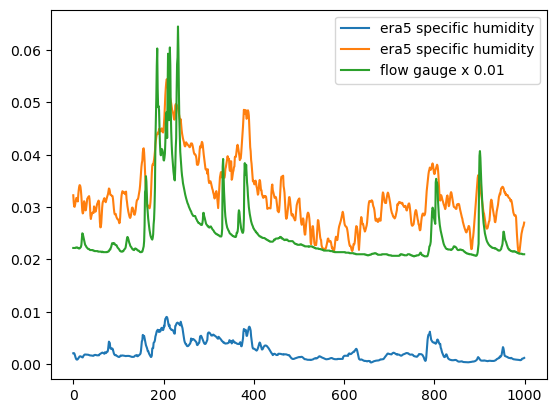

In [14]:
df_merged = pd.merge(df_all, df_era5, on='utc_timestamp')
fig, ax = plt.subplots(1)
ax.plot(df_merged['q-700'], label='era5 specific humidity')
ax.plot(df_merged['tcwv'] * 0.001, label='era5 specific humidity')
ax.plot(df_merged['measurement'] * 0.01, label='flow gauge x 0.01')
ax.legend()